In [2]:
import pandas as pd
import numpy as np
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianModel
from pgmpy.estimators import K2Score
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator
import re
from tqdm import tqdm

In [26]:
features = pd.read_csv('15features.csv')
features.head(5)

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


In [4]:
training_pairs = pd.read_csv('seen-dataset/dataset_seen_training_siamese.csv')
validation_pairs = pd.read_csv('seen-dataset/dataset_seen_validation_siamese.csv')

In [5]:
training_features_pairs_info = pd.merge(training_pairs,features,left_on='left',right_on='imagename')
training_features_pairs_info = pd.merge(training_features_pairs_info,
                                        features,left_on='right',
                                        right_on='imagename', 
                                        suffixes=('1', '2'))
training_features_pairs_info = training_features_pairs_info.drop(training_features_pairs_info.columns[[0,4,20]],
                                                                 axis=1)
training_features_pairs = training_features_pairs_info.drop(training_features_pairs_info.columns[[0,1]],
                                                       axis=1)

validation_features_pairs_info = pd.merge(validation_pairs,features,left_on='left',right_on='imagename')
validation_features_pairs_info = pd.merge(validation_features_pairs_info,features,
                                          left_on='right',
                                          right_on='imagename', 
                                          suffixes=('1', '2'))
validation_features_pairs_info = validation_features_pairs_info.drop(validation_features_pairs_info.columns[[0,4,20]],
                                                                     axis=1)
validation_features_pairs = validation_features_pairs_info.drop(validation_features_pairs_info.columns[[0,1]],axis=1)

training_features_pairs.to_csv('training_features.csv')

In [11]:
combined_model = BayesianModel([('is_lowercase1','is_lowercase_sim'),
                                ('is_lowercase2','is_lowercase_sim'),
                                ('is_continuous1','is_continuous_sim'),
                                ('is_continuous2','is_continuous_sim'),
                                ('is_lowercase_sim','is_continuous_sim'),
                                ('dimension1','dimension_sim'),
                                ('dimension2','dimension_sim'),
                                ('letter_spacing1','letter_spacing_sim'),
                                ('letter_spacing2','letter_spacing_sim'),
                                ('size1','size_sim'),
                                ('size2','size_sim'),
                                ('dimension_sim','size_sim'),
                                ('letter_spacing_sim','size_sim'),
                                ('constancy1','constancy_sim'),
                                ('constancy2','constancy_sim'),
                                ('size_sim','constancy_sim'),
                                ('word_formation1','word_formation_sim'),
                                ('word_formation2','word_formation_sim'),
                                ('constancy_sim','word_formation_sim'),
                                ('formation_n1','formation_n_sim'),
                                ('formation_n2','formation_n_sim'),
                                ('word_formation_sim','formation_n_sim'),
                                ('entry_stroke_a1','entry_stroke_a_sim'),
                                ('entry_stroke_a2', 'entry_stroke_a_sim')
                               ])
# nx.draw(combined_model, **options)

cpd_is_lowercase1 = TabularCPD('is_lowercase1',2,[[0.5],
                                                [0.5]],
                                                evidence=[], evidence_card=[])
cpd_is_lowercase2 = TabularCPD('is_lowercase2',2,[[0.5],
                                                [0.5]],
                                                evidence=[], evidence_card=[])
cpd_is_continuous1 = TabularCPD('is_continuous1',2,[[0.5],
                                                [0.5]],
                                                evidence=[], evidence_card=[])
cpd_is_continuous2 = TabularCPD('is_continuous2',2,[[0.5],
                                                [0.5]],
                                                evidence=[], evidence_card=[])
cpd_dimension1 = TabularCPD('dimension1',3,[[0.33],
                                    [0.34],[0.33]],
                                                evidence=[], evidence_card=[])
cpd_dimension2 = TabularCPD('dimension2',3,[[0.33],
                                    [0.34],[0.33]],
                                                evidence=[], evidence_card=[])
cpd_letter_spacing1 = TabularCPD('letter_spacing1',3,[[0.33],
                                    [0.34],[0.33]],
                                    evidence=[], evidence_card=[])
cpd_letter_spacing2 = TabularCPD('letter_spacing2',3,[[0.33],
                                    [0.34],[0.33]],
                                    evidence=[], evidence_card=[])
cpd_size1 = TabularCPD('size1',3,[[0.33],
                                    [0.34],[0.33]],
                                    evidence=[], evidence_card=[])
cpd_size2 = TabularCPD('size2',3,[[0.33],
                                    [0.34],[0.33]],
                                    evidence=[], evidence_card=[])
cpd_constancy1 = TabularCPD('constancy1',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_constancy2 = TabularCPD('constancy2',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_word_formation1 = TabularCPD('word_formation1',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_word_formation2 = TabularCPD('word_formation2',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_formation_n1 = TabularCPD('formation_n1',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_formation_n2 = TabularCPD('formation_n2',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_entry_stroke_a1 = TabularCPD('entry_stroke_a1',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_entry_stroke_a2 = TabularCPD('entry_stroke_a2',2,[[0.5],
                                    [0.5]],
                                    evidence=[], evidence_card=[])
cpd_is_lowercase_sim = TabularCPD('is_lowercase_sim',2,[[0.1,0.9,0.9,0.1],
                                                            [0.9,0.1,0.1,0.9]],
                                                            evidence=['is_lowercase1','is_lowercase2'], 
                                                            evidence_card=[2,2])
cpd_is_continuous_sim = TabularCPD('is_continuous_sim',2,[[0.9,0.1,0.9,0.6,0.9,0.6,0.9,0.1],
                                                            [0.1,0.9,0.1,0.4,0.1,0.4,0.1,0.9]],
                                                            evidence=['is_continuous1','is_continuous2','is_lowercase_sim'], 
                                                            evidence_card=[2,2,2])
cpd_dimension_sim = TabularCPD('dimension_sim',2,[[0.1,0.8,0.9,0.8,0.1,0.8,0.9,0.8,0.1],
                                                [0.9,0.2,0.1,0.2,0.9,0.2,0.1,0.2,0.9]],
                                                evidence=['dimension1','dimension2'], evidence_card=[3,3])
cpd_letter_spacing_sim = TabularCPD('letter_spacing_sim',2,[[0.1,0.8,0.9,0.8,0.1,0.8,0.9,0.8,0.1],
                                                [0.9,0.2,0.1,0.2,0.9,0.2,0.1,0.2,0.9]],
                                                evidence=['letter_spacing1','letter_spacing2'], evidence_card=[3,3])
cpd_size_sim = TabularCPD('size_sim',2,[[0.6,0.3,0.3,0.1,0.8,0.7,0.7,0.3,0.9,0.8,0.7,0.4,0.7,0.6,0.6,0.3,0.6,0.3,0.3,0.1,0.8,0.4,0.4,0.85,0.9,0.8,0.8,0.3,0.8,0.4,0.4,0.85,0.6,0.3,0.3,0.1],
                                        [0.4,0.7,0.7,0.9,0.2,0.3,0.3,0.7,0.1,0.2,0.3,0.6,0.3,0.4,0.4,0.7,0.4,0.7,0.7,0.9,0.2,0.6,0.6,0.15,0.1,0.2,0.2,0.7,0.2,0.6,0.6,0.15,0.4,0.7,0.7,0.9]],
                                        evidence=['size1','size2','dimension_sim','letter_spacing_sim'], evidence_card=[3,3,2,2])
cpd_constancy_sim = TabularCPD('constancy_sim',2,[[0.9,0.1,0.9,0.6,0.9,0.6,0.7,0.1],
                                        [0.1,0.9,0.1,0.4,0.1,0.4,0.3,0.9]],
                                        evidence=['constancy1','constancy2','size_sim'], evidence_card=[2,2,2])
cpd_word_formation_sim = TabularCPD('word_formation_sim',2,[[0.9,0.1,0.9,0.7,0.9,0.7,0.9,0.1],
                                        [0.1,0.9,0.1,0.3,0.1,0.3,0.1,0.9]],
                                        evidence=['word_formation1','word_formation2','constancy_sim'], evidence_card=[2,2,2])
cpd_formation_n_sim = TabularCPD('formation_n_sim',2,[[0.7,0.1,0.9,0.4,0.9,0.4,0.6,0.1],
                                        [0.3,0.9,0.1,0.6,0.1,0.6,0.4,0.9]],
                                        evidence=['formation_n1','formation_n2','word_formation_sim'], evidence_card=[2,2,2])
cpd_entry_stroke_a_sim = TabularCPD('entry_stroke_a_sim',2,[[0.1,0.9,0.9,0.1],
                                                            [0.9,0.1,0.1,0.9]],
                                        evidence=['entry_stroke_a1','entry_stroke_a2'], evidence_card=[2,2])

combined_model.add_cpds(cpd_is_lowercase1,
                        cpd_is_lowercase2,
                        cpd_is_lowercase_sim,
                        cpd_is_continuous1,
                        cpd_is_continuous2,
                        cpd_is_continuous_sim,
                        cpd_dimension1,
                        cpd_dimension2,
                        cpd_dimension_sim,
                        cpd_letter_spacing1,
                        cpd_letter_spacing2,
                        cpd_letter_spacing_sim,
                        cpd_size1,
                        cpd_size2,
                        cpd_size_sim,
                        cpd_constancy1,
                        cpd_constancy2,
                        cpd_constancy_sim,
                        cpd_word_formation1,
                        cpd_word_formation2,
                        cpd_word_formation_sim,
                        cpd_formation_n1,
                        cpd_formation_n2,
                        cpd_formation_n_sim,
                        cpd_entry_stroke_a1,
                        cpd_entry_stroke_a2,
                        cpd_entry_stroke_a_sim
                       )
combined_model.check_model()

True

,features,feature similarity score
0,constancy,0.00
1,word_formation,0.00
2,exit_stroke_d,0.00
3,staff_of_d,0.00
4,formation_n,0.00
5,staff_of_a,0.00
6,entry_stroke_a,0.00
7,tilt,0.50
8,slantness,0.57
9,is_continuous,0.37


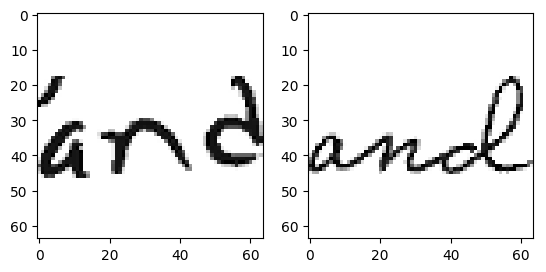

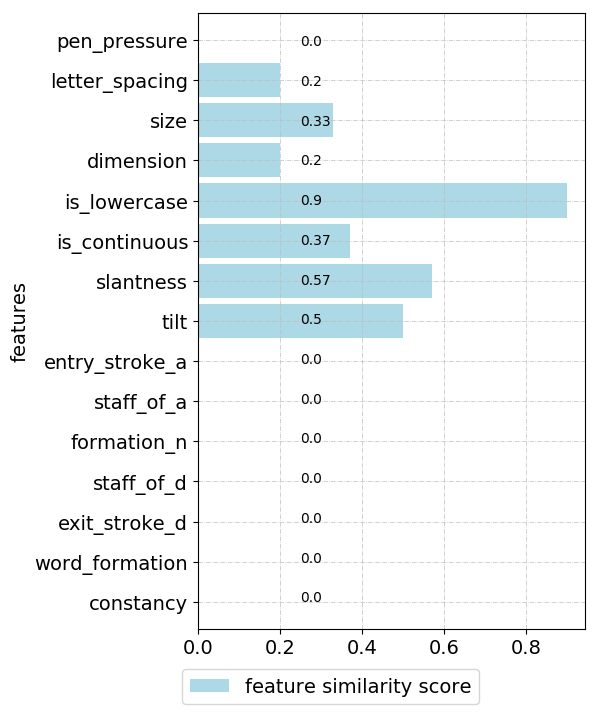

In [39]:
mle = VariableElimination(combined_model)
feat = {'letter_spacing1',
        'size1',
        'dimension1',
        'is_lowercase1',
        'is_continuous1',
        'formation_n1',
        'constancy1',
        'letter_spacing2',
        'size2',
        'dimension2',
        'is_lowercase2',
        'is_continuous2',
        'formation_n2',
        'constancy2'}

var = {'letter_spacing_sim',
       'size_sim',
       'dimension_sim',
       'is_lowercase_sim',
       'is_continuous_sim',
       'formation_n_sim',
       'constancy_sim'}

import numpy as np
import matplotlib.image as mpimg
counter = 0
acc_counter = 0
count_1 = 0 
count_0 = 0
count_1_1 = 0
count_0_0 = 0
count_1_0 = 0
count_0_1 = 0

for index, row in validation_features_pairs_info.iterrows():
    
    evidence = {}
    for f in feat:
        evidence[f] = row[f] - 1
    mle1 = mle.query(variables=var, 
                        evidence=evidence)
    counter = counter + 1
    total = mle1['letter_spacing_sim'].values[1]*100+ mle1['size_sim'].values[1]*100+ mle1['size_sim'].values[1]*100+ mle1['is_lowercase_sim'].values[1]*100+mle1['is_continuous_sim'].values[1]*100+mle1['formation_n_sim'].values[1]*100+mle1['constancy_sim'].values[1]*100
    total = total/7
    if(total > 50):
        label = 1
        count_1 += 1
    else:
        label = 0
        count_0 += 1
    if(label == row['label']):
        if(label == 1):
            count_1_1 += 1
        else:
            count_0_0 += 1
        acc_counter += 1
    else:
        if(label == 1):
            count_1_0 += 1
        else:
            count_0_1 += 1
    if(counter == 3):
        f, axarr = plt.subplots(1,2)

        img1 = mpimg.imread('seen-dataset/ValidationSet/' + row['left'])
        img2 = mpimg.imread('seen-dataset/ValidationSet/' + row['right'])

        axarr[0].imshow(img1)
        axarr[1].imshow(img2)
        
        plt.rcdefaults()

        # Example data
        performance = np.round([0,
                                mle1['letter_spacing_sim'].values[1],
                                mle1['size_sim'].values[1],
                                mle1['dimension_sim'].values[1],
                                mle1['is_lowercase_sim'].values[1],
                                mle1['is_continuous_sim'].values[1],
                                mle1['formation_n_sim'].values[1],
                                mle1['constancy_sim'].values[1],
                                0,
                                0,
                                0,
                                0,
                                0,
                                0,
                                0],2)
        df_feat_sim_score = pd.DataFrame()
        df_feat_sim_score['features']=list(reversed(features.keys()[1:]))
        df_feat_sim_score['feature similarity score']=list(reversed(performance))
        display(df_feat_sim_score)
        ax = df_feat_sim_score.plot.barh(width=0.85
                                         , rot=0
                                         , x='features'
                                         , color='lightblue'
                                         , fontsize=14
                                         , figsize=(5,8)
                                         , grid=True)
        df_feat_sim_score['feature similarity score'].mean()

        ax.legend(bbox_to_anchor=(0.75,-0.05)
                  , fontsize=14)
        ax.grid(color='#bebebe'
                , linestyle='-.'
                , linewidth=0.5)
        plt.ylabel('features',fontsize=14)
        counter=-1
        for p in ax.patches:
            counter+=1
            ax.annotate(str(p.get_width()), (0.25, counter*0.99))
        break

In [7]:
print('Validation Accuracy is: ' + str(round((acc_counter/counter),3)*100))

NameError: name 'acc_counter' is not defined

In [8]:
# print('True Positive:  ' + str(round(count_1_1/(count_1_1+count_0_1)*100,2)) + '%')
# print('True Negative:  ' + str(round(count_0_0/(count_0_0+count_1_0)*100,2)) + '%')
# print('False Positive: ' + str(round(count_1_0/(count_1_0+count_0_0)*100,2)) + '%')
# print('False Negative: ' + str(round(count_0_1/(count_1_1+count_0_1)*100,2)) + '%')